In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import cv2
import joblib
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD, AdamW, Ftrl, Adamax
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2023-08-06 08:32:27.378811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:
1. кількість шарів;
1. кількість нейронів;
1. функції активації;
1. кількість епох;
1. розмір батчу;
1. вибір оптимізатора;
1. різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.


In [2]:
num_classes = 10
num_features = 28 * 28

learning_rate = 0.001
n_epochs = 20
batch_size = 256

In [17]:
from tensorflow.keras.datasets import fashion_mnist
data_set_fashion = fashion_mnist.load_data()

4422102/4422102 [==============================] - 6s 1us/step


In [18]:
joblib.dump(data_set_fashion, "data_set_fashion")

['data_set_fashion']

In [3]:
data_set_fashion = joblib.load( "data_set_fashion")

In [4]:
(x_train_all, y_train_all), (x_test, y_test) = data_set_fashion
x_train_all, x_test = np.array(x_train_all, np.float32), np.array(x_test, np.float32)
x_train_all, x_test = x_train_all.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train_all, x_test = x_train_all / 255., x_test / 255.
class_to_label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4 :"Coat",
    5: "Sandal",
    6 :"Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


'Sandal'

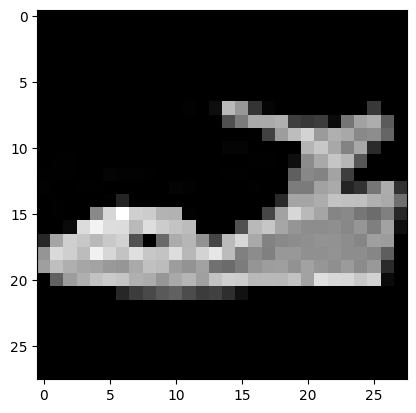

In [5]:
i_sample = 10555
plt.imshow(x_train_all[i_sample].reshape(28, 28), cmap="gray")
class_to_label[y_train_all[i_sample]]

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.2, shuffle=True)

In [8]:
x_train.shape , x_valid.shape

((48000, 784), (12000, 784))

In [9]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, shuffle=True, batch_size=256):
        self.x = x
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x))
        self.batch_size = batch_size

        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        # batch_x = [self.x[i].reshape(num_features) for i in indexes]
        batch_x = [self.x[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], num_classes) for i in indexes]


        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [9]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=256)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=256)

In [10]:
# Test layers = 3, learning_rate = 0.001, n_epochs = 20, batch_size = 256
model = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(num_features,)),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[CategoricalAccuracy()],
)

In [12]:
callback_early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1
)


callback_save = ModelCheckpoint(
    "best.hdf5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [13]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    verbose=1,
    callbacks=[callback_early_stopping, callback_save]
)

Epoch 1/20
187/188 [============================>.] - ETA: 0s - loss: 0.5015 - categorical_accuracy: 0.8183
Epoch 1: val_loss improved from inf to 0.40404, saving model to best.hdf5
188/188 [==============================] - 8s 39ms/step - loss: 0.5008 - categorical_accuracy: 0.8187 - val_loss: 0.4040 - val_categorical_accuracy: 0.8512
Epoch 2/20
  1/188 [..............................] - ETA: 10s - loss: 0.4126 - categorical_accuracy: 0.8398

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/188 [============================>.] - ETA: 0s - loss: 0.3564 - categorical_accuracy: 0.8687
Epoch 2: val_loss improved from 0.40404 to 0.35725, saving model to best.hdf5
188/188 [==============================] - 9s 47ms/step - loss: 0.3562 - categorical_accuracy: 0.8687 - val_loss: 0.3572 - val_categorical_accuracy: 0.8687
Epoch 3/20
187/188 [============================>.] - ETA: 0s - loss: 0.3194 - categorical_accuracy: 0.8811
Epoch 3: val_loss improved from 0.35725 to 0.32320, saving model to best.hdf5
188/188 [==============================] - 9s 46ms/step - loss: 0.3194 - categorical_accuracy: 0.8810 - val_loss: 0.3232 - val_categorical_accuracy: 0.8802
Epoch 4/20
187/188 [============================>.] - ETA: 0s - loss: 0.2952 - categorical_accuracy: 0.8887
Epoch 4: val_loss did not improve from 0.32320
188/188 [==============================] - 7s 38ms/step - loss: 0.2951 - categorical_accuracy: 0.8888 - val_loss: 0.3497 - val_categorical_accuracy: 0.8702
Epoch 5/20
187/1

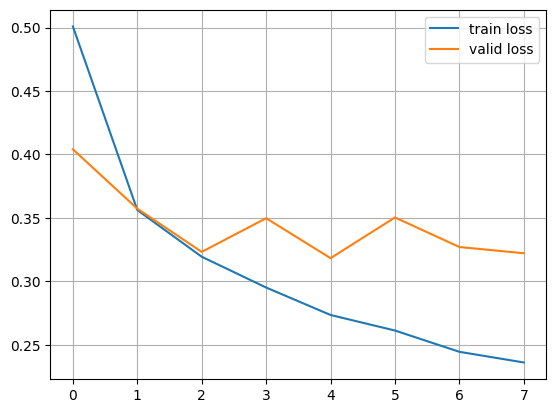

In [14]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.grid()

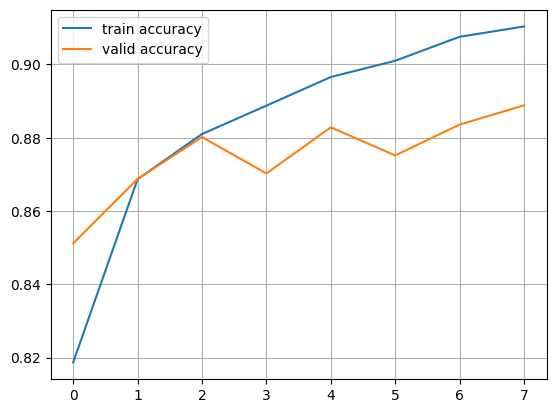

In [15]:
plt.plot(history.history["categorical_accuracy"], label="train accuracy")
plt.plot(history.history["val_categorical_accuracy"], label="valid accuracy")
plt.legend()
plt.grid()

In [16]:
test_out = model(x_test).numpy()

In [17]:
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)
print(f"Accuracy test data: {accuracy_test.round(4)}" )

Accuracy test data: 0.8858


Test data - layers = 3, learning_rate = 0.001, n_epochs = 10, batch_size = 256, optimizer=Adam

**Accuracy: 0.8838**

In [36]:
# Test number of layers.  learning_rate = 0.001, n_epochs = 10, batch_size = 256
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=256)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=256)

In [49]:
learning_rate = 0.001
n_epochs = 20
batch_size = 256
layers = [1, 2, 3, 4] # not include finish layer with softmax but include start layer

In [38]:
conf_dense_start = Dense(1024, activation="relu", input_shape=(num_features,))
conf_dense_layer = Dense(1024, activation="relu")
conf_dense_end = Dense(10, activation="softmax")

In [39]:
res_accuracy = []
for n_layers in layers:

  conf_dense = []
  conf_dense.append(conf_dense_start)
  if n_layers > 1:
    for _ in range(n_layers-1):
      conf_dense.append(conf_dense_layer)
  conf_dense.append(conf_dense_end)

  model_ = Sequential(conf_dense)

  model_.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  model_.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping]
  )

  test_out = model_(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)

  print()
  print(f"Accuracy test data: layer {n_layers} - {accuracy_test.round(4)}" )
  print()

Epoch 1/20
188/188 [==============================] - 3s 12ms/step - loss: 0.5505 - categorical_accuracy: 0.8091 - val_loss: 0.4182 - val_categorical_accuracy: 0.8528
Epoch 2/20
188/188 [==============================] - 2s 11ms/step - loss: 0.3849 - categorical_accuracy: 0.8646 - val_loss: 0.3998 - val_categorical_accuracy: 0.8549
Epoch 3/20
188/188 [==============================] - 2s 11ms/step - loss: 0.3505 - categorical_accuracy: 0.8738 - val_loss: 0.3763 - val_categorical_accuracy: 0.8629
Epoch 4/20
188/188 [==============================] - 2s 11ms/step - loss: 0.3182 - categorical_accuracy: 0.8853 - val_loss: 0.3349 - val_categorical_accuracy: 0.8797
Epoch 5/20
188/188 [==============================] - 2s 11ms/step - loss: 0.2938 - categorical_accuracy: 0.8942 - val_loss: 0.3351 - val_categorical_accuracy: 0.8759
Epoch 6/20
188/188 [==============================] - 2s 11ms/step - loss: 0.2785 - categorical_accuracy: 0.8986 - val_loss: 0.3389 - val_categorical_accuracy: 0.872


Accuracy test data: layer 1 - 0.8576

Epoch 1/20
188/188 [==============================] - 5s 25ms/step - loss: 0.3611 - categorical_accuracy: 0.8740 - val_loss: 0.3515 - val_categorical_accuracy: 0.8673
Epoch 2/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2637 - categorical_accuracy: 0.9033 - val_loss: 0.3304 - val_categorical_accuracy: 0.8802
Epoch 3/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2440 - categorical_accuracy: 0.9094 - val_loss: 0.3034 - val_categorical_accuracy: 0.8908
Epoch 4/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2308 - categorical_accuracy: 0.9139 - val_loss: 0.3378 - val_categorical_accuracy: 0.8790
Epoch 5/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2211 - categorical_accuracy: 0.9176 - val_loss: 0.3188 - val_categorical_accuracy: 0.8878
Epoch 6/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2115 - categorical_accuracy: 0.9214 - val_loss: 0


Accuracy test data: layer 2 - 0.8738

Epoch 1/20
188/188 [==============================] - 7s 36ms/step - loss: 0.2207 - categorical_accuracy: 0.9187 - val_loss: 0.3220 - val_categorical_accuracy: 0.8896
Epoch 2/20
188/188 [==============================] - 7s 35ms/step - loss: 0.1991 - categorical_accuracy: 0.9264 - val_loss: 0.3301 - val_categorical_accuracy: 0.8892
Epoch 3/20
188/188 [==============================] - 7s 35ms/step - loss: 0.1902 - categorical_accuracy: 0.9287 - val_loss: 0.3248 - val_categorical_accuracy: 0.8950
Epoch 4/20
188/188 [==============================] - 7s 35ms/step - loss: 0.1820 - categorical_accuracy: 0.9314 - val_loss: 0.3530 - val_categorical_accuracy: 0.8860
Epoch 4: early stopping

Accuracy test data: layer 3 - 0.8834



In [ ]:
Its strange calculating because loss saving between models. Try another way.

In [44]:
conf_dense = [conf_dense_start, conf_dense_end]
res_accuracy = []

model_1 = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(num_features,)),
        Dense(10, activation="softmax"),
    ]
)

model_1.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss="categorical_crossentropy",
  metrics=[CategoricalAccuracy()],
)

model_1.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=n_epochs,
  verbose=1,
  callbacks=[callback_early_stopping]
)

test_out = model_1(x_test).numpy()
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

res_accuracy.append(accuracy_test)

print()
print(f"Accuracy test data: layer 1 - {accuracy_test.round(4)}" )
print()

Epoch 1/20
188/188 [==============================] - 3s 12ms/step - loss: 0.5504 - categorical_accuracy: 0.8074 - val_loss: 0.4312 - val_categorical_accuracy: 0.8503
Epoch 2/20
188/188 [==============================] - 2s 12ms/step - loss: 0.3897 - categorical_accuracy: 0.8642 - val_loss: 0.3914 - val_categorical_accuracy: 0.8608
Epoch 3/20
188/188 [==============================] - 2s 11ms/step - loss: 0.3496 - categorical_accuracy: 0.8747 - val_loss: 0.3540 - val_categorical_accuracy: 0.8718
Epoch 4/20
188/188 [==============================] - 2s 12ms/step - loss: 0.3203 - categorical_accuracy: 0.8850 - val_loss: 0.3537 - val_categorical_accuracy: 0.8698
Epoch 5/20
188/188 [==============================] - 2s 12ms/step - loss: 0.2973 - categorical_accuracy: 0.8919 - val_loss: 0.3167 - val_categorical_accuracy: 0.8840
Epoch 6/20
188/188 [==============================] - 2s 12ms/step - loss: 0.2796 - categorical_accuracy: 0.8993 - val_loss: 0.3290 - val_categorical_accuracy: 0.876

In [45]:
model_2 = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(num_features,)),
        Dense(1024, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

model_2.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss="categorical_crossentropy",
  metrics=[CategoricalAccuracy()],
)

model_2.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=n_epochs,
  verbose=1,
  callbacks=[callback_early_stopping]
)

test_out = model_2(x_test).numpy()
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

res_accuracy.append(accuracy_test)

print()
print(f"Accuracy test data: layer 2 - {accuracy_test.round(4)}" )
print()

Epoch 1/20
188/188 [==============================] - 5s 25ms/step - loss: 0.5054 - categorical_accuracy: 0.8216 - val_loss: 0.3889 - val_categorical_accuracy: 0.8586
Epoch 2/20
188/188 [==============================] - 5s 25ms/step - loss: 0.3540 - categorical_accuracy: 0.8704 - val_loss: 0.3748 - val_categorical_accuracy: 0.8584
Epoch 3/20
188/188 [==============================] - 5s 25ms/step - loss: 0.3192 - categorical_accuracy: 0.8813 - val_loss: 0.3520 - val_categorical_accuracy: 0.8708
Epoch 4/20
188/188 [==============================] - 5s 25ms/step - loss: 0.2880 - categorical_accuracy: 0.8933 - val_loss: 0.3130 - val_categorical_accuracy: 0.8839
Epoch 5/20
188/188 [==============================] - 5s 25ms/step - loss: 0.2703 - categorical_accuracy: 0.8996 - val_loss: 0.3402 - val_categorical_accuracy: 0.8758
Epoch 6/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2629 - categorical_accuracy: 0.9025 - val_loss: 0.3132 - val_categorical_accuracy: 0.884

In [46]:
model_3 = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(num_features,)),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

model_3.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss="categorical_crossentropy",
  metrics=[CategoricalAccuracy()],
)

model_3.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=n_epochs,
  verbose=1,
  callbacks=[callback_early_stopping]
)

test_out = model_3(x_test).numpy()
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

res_accuracy.append(accuracy_test)

print()
print(f"Accuracy test data: layer 3 - {accuracy_test.round(4)}" )
print()

Epoch 1/20
188/188 [==============================] - 8s 38ms/step - loss: 0.5218 - categorical_accuracy: 0.8075 - val_loss: 0.3977 - val_categorical_accuracy: 0.8559
Epoch 2/20
188/188 [==============================] - 7s 39ms/step - loss: 0.3590 - categorical_accuracy: 0.8684 - val_loss: 0.3620 - val_categorical_accuracy: 0.8678
Epoch 3/20
188/188 [==============================] - 8s 40ms/step - loss: 0.3156 - categorical_accuracy: 0.8834 - val_loss: 0.3390 - val_categorical_accuracy: 0.8735
Epoch 4/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2953 - categorical_accuracy: 0.8881 - val_loss: 0.3402 - val_categorical_accuracy: 0.8729
Epoch 5/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2729 - categorical_accuracy: 0.8969 - val_loss: 0.3162 - val_categorical_accuracy: 0.8843
Epoch 6/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2559 - categorical_accuracy: 0.9028 - val_loss: 0.3209 - val_categorical_accuracy: 0.883

In [50]:
model_4 = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(num_features,)),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

model_4.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss="categorical_crossentropy",
  metrics=[CategoricalAccuracy()],
)

model_4.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=n_epochs,
  verbose=1,
  callbacks=[callback_early_stopping]
)

test_out = model_4(x_test).numpy()
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

res_accuracy.append(accuracy_test)

print()
print(f"Accuracy test data: layer 3 - {accuracy_test.round(4)}" )
print()

Epoch 1/20
188/188 [==============================] - 10s 49ms/step - loss: 0.5235 - categorical_accuracy: 0.8080 - val_loss: 0.4071 - val_categorical_accuracy: 0.8505
Epoch 2/20
188/188 [==============================] - 9s 49ms/step - loss: 0.3660 - categorical_accuracy: 0.8656 - val_loss: 0.3694 - val_categorical_accuracy: 0.8652
Epoch 3/20
188/188 [==============================] - 10s 51ms/step - loss: 0.3237 - categorical_accuracy: 0.8799 - val_loss: 0.3403 - val_categorical_accuracy: 0.8756
Epoch 4/20
188/188 [==============================] - 10s 54ms/step - loss: 0.2977 - categorical_accuracy: 0.8907 - val_loss: 0.3369 - val_categorical_accuracy: 0.8785
Epoch 5/20
188/188 [==============================] - 9s 50ms/step - loss: 0.2795 - categorical_accuracy: 0.8956 - val_loss: 0.3421 - val_categorical_accuracy: 0.8758
Epoch 6/20
188/188 [==============================] - 10s 51ms/step - loss: 0.2639 - categorical_accuracy: 0.9013 - val_loss: 0.3230 - val_categorical_accuracy: 0

In [51]:
res_accuracy

[0.8755, 0.879, 0.8791, 0.8826]

In [52]:
# the best number of layers
layers[res_accuracy.index(max(res_accuracy))]

4

Mean number of layers with the best accuracy is 4 but from 1 to 4 number of layers too small different. Model with 4 or more layers become overfit.

In [53]:
# Test number of units.  learning_rate = 0.001, n_epochs = 10, batch_size = 256, layers = 3
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=256)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=256)

In [54]:
learning_rate = 0.001
layers = 2
n_epochs = 20
batch_size = 256
units = [256, 512, 1024, 2048, 4096] #

In [56]:
res_accuracy = []
for n_units in units:

  conf_dense = [
        Dense(n_units, activation="relu", input_shape=(num_features,)),
        Dense(n_units, activation="relu"),
        Dense(10, activation="softmax"),
    ]

  model = Sequential(conf_dense)

  model.compile(
      optimizer=AdamW(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping]
  )

  test_out = model(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)
  print()
  print(f"Accuracy test data: units {n_units} {accuracy_test.round(4)}" )
  print()

Epoch 1/20
188/188 [==============================] - 2s 8ms/step - loss: 0.5722 - categorical_accuracy: 0.7977 - val_loss: 0.4527 - val_categorical_accuracy: 0.8357
Epoch 2/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3914 - categorical_accuracy: 0.8594 - val_loss: 0.3987 - val_categorical_accuracy: 0.8528
Epoch 3/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3453 - categorical_accuracy: 0.8760 - val_loss: 0.3524 - val_categorical_accuracy: 0.8728
Epoch 4/20
188/188 [==============================] - 1s 8ms/step - loss: 0.3164 - categorical_accuracy: 0.8849 - val_loss: 0.3742 - val_categorical_accuracy: 0.8627
Epoch 5/20
188/188 [==============================] - 1s 8ms/step - loss: 0.2962 - categorical_accuracy: 0.8917 - val_loss: 0.3324 - val_categorical_accuracy: 0.8771
Epoch 6/20
188/188 [==============================] - 1s 8ms/step - loss: 0.2789 - categorical_accuracy: 0.8961 - val_loss: 0.3272 - val_categorical_accuracy: 0.8777
Epoc

In [57]:
# the best number of units
units[res_accuracy.index(max(res_accuracy))]

512

Number of units with the best accuracy is 512 but 256 and 1024 also has good accuracy. Model 4096 or more layers become overfit and increase time from 2 to 65 seconds.

In [58]:
# Test activation function.
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=256)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=256)

In [69]:
learning_rate = 0.001
n_units = 1024
n_epochs = 20
batch_size = 256
layers = 2
activate_funcions = ["relu", "sigmoid", "tanh"]

In [70]:
res_accuracy = []
for act in activate_funcions:

  conf_dense = [
        Dense(n_units, activation=act, input_shape=(num_features,)),
        Dense(n_units, activation=act),
        Dense(10, activation="softmax"),
    ]

  model = Sequential(conf_dense)

  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping]
  )

  test_out = model(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)
  print()
  print(f"Accuracy test data: func {act} {accuracy_test.round(4)}" )
  print()

Epoch 1/20
188/188 [==============================] - 5s 26ms/step - loss: 0.5021 - categorical_accuracy: 0.8213 - val_loss: 0.3859 - val_categorical_accuracy: 0.8605
Epoch 2/20
188/188 [==============================] - 5s 25ms/step - loss: 0.3588 - categorical_accuracy: 0.8699 - val_loss: 0.3638 - val_categorical_accuracy: 0.8682
Epoch 3/20
188/188 [==============================] - 5s 25ms/step - loss: 0.3198 - categorical_accuracy: 0.8825 - val_loss: 0.3404 - val_categorical_accuracy: 0.8743
Epoch 4/20
188/188 [==============================] - 5s 25ms/step - loss: 0.2945 - categorical_accuracy: 0.8913 - val_loss: 0.3249 - val_categorical_accuracy: 0.8813
Epoch 5/20
188/188 [==============================] - 5s 25ms/step - loss: 0.2786 - categorical_accuracy: 0.8953 - val_loss: 0.3439 - val_categorical_accuracy: 0.8736
Epoch 6/20
188/188 [==============================] - 5s 26ms/step - loss: 0.2586 - categorical_accuracy: 0.9039 - val_loss: 0.3290 - val_categorical_accuracy: 0.879

In [73]:
res_accuracy

[0.8733, 0.8583, 0.8806]

In [71]:
# the best activate_funcions
activate_funcions[res_accuracy.index(max(res_accuracy))]

'tanh'

The best activation function is tanh. relu also had good result

In [10]:
# Test batch size.
learning_rate = 0.001
n_units = 1024
n_epochs = 20
batch_sizes = [256, 512, 1024, 2048]
layers = 2
activate_funcion = "tanh"

In [13]:
res_accuracy = []
for batch_s in batch_sizes:
  train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_s)
  valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_s)

  conf_dense = [
        Dense(n_units, activation=activate_funcion, input_shape=(num_features,)),
        Dense(n_units, activation=activate_funcion),
        Dense(10, activation="softmax"),
    ]

  model = Sequential(conf_dense)

  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping]
  )

  test_out = model(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)
  print()
  print(f"Accuracy test data: batch_size {batch_s} {accuracy_test.round(4)}" )
  print()

Epoch 1/20
188/188 [==============================] - 5s 26ms/step - loss: 0.5703 - categorical_accuracy: 0.8009 - val_loss: 0.4096 - val_categorical_accuracy: 0.8521
Epoch 2/20
188/188 [==============================] - 5s 25ms/step - loss: 0.4081 - categorical_accuracy: 0.8545 - val_loss: 0.3937 - val_categorical_accuracy: 0.8563
Epoch 3/20
188/188 [==============================] - 5s 24ms/step - loss: 0.3602 - categorical_accuracy: 0.8688 - val_loss: 0.3641 - val_categorical_accuracy: 0.8673
Epoch 4/20
188/188 [==============================] - 5s 24ms/step - loss: 0.3338 - categorical_accuracy: 0.8766 - val_loss: 0.3645 - val_categorical_accuracy: 0.8683
Epoch 5/20
188/188 [==============================] - 5s 24ms/step - loss: 0.3155 - categorical_accuracy: 0.8821 - val_loss: 0.3309 - val_categorical_accuracy: 0.8813
Epoch 6/20
188/188 [==============================] - 5s 24ms/step - loss: 0.2960 - categorical_accuracy: 0.8896 - val_loss: 0.3622 - val_categorical_accuracy: 0.867

In [14]:
res_accuracy

[0.8716, 0.8821, 0.8688, 0.8667]

In [15]:
# the best batch_size
batch_sizes[res_accuracy.index(max(res_accuracy))]

512

The best batch_size is 512

In [18]:
# Test optimizer
learning_rate = 0.001
n_units = 1024
n_epochs = 30
batch_size = 512
layers = 2
activate_funcion = "tanh"

In [19]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)

In [20]:
optimizers = [Adam(lr=learning_rate), SGD(lr=learning_rate), AdamW(lr=learning_rate), Ftrl(lr=learning_rate)]
name_optimizers = ["Adam", "SGD", "AdamW", "Ftrl"]

In [21]:
res_accuracy = []
for n_opt, opt in enumerate(optimizers, start=0):

  conf_dense = [
        Dense(n_units, activation=activate_funcion, input_shape=(num_features,)),
        Dense(n_units, activation=activate_funcion),
        Dense(10, activation="softmax"),
    ]

  model = Sequential(conf_dense)

  model.compile(
      optimizer=opt,
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping]
  )

  test_out = model(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)
  print()
  print(f"Accuracy test data: optimazer {name_optimizers[n_opt]} {accuracy_test.round(4)}" )
  print()

Epoch 1/30
94/94 [==============================] - 4s 43ms/step - loss: 0.6690 - categorical_accuracy: 0.7755 - val_loss: 0.4600 - val_categorical_accuracy: 0.8344
Epoch 2/30
94/94 [==============================] - 4s 43ms/step - loss: 0.4086 - categorical_accuracy: 0.8540 - val_loss: 0.4069 - val_categorical_accuracy: 0.8528
Epoch 3/30
94/94 [==============================] - 4s 43ms/step - loss: 0.3842 - categorical_accuracy: 0.8626 - val_loss: 0.3917 - val_categorical_accuracy: 0.8588
Epoch 4/30
94/94 [==============================] - 4s 43ms/step - loss: 0.3625 - categorical_accuracy: 0.8684 - val_loss: 0.3698 - val_categorical_accuracy: 0.8679
Epoch 5/30
94/94 [==============================] - 4s 41ms/step - loss: 0.3330 - categorical_accuracy: 0.8780 - val_loss: 0.3527 - val_categorical_accuracy: 0.8701
Epoch 6/30
94/94 [==============================] - 4s 44ms/step - loss: 0.3217 - categorical_accuracy: 0.8823 - val_loss: 0.3443 - val_categorical_accuracy: 0.8789
Epoch 7/30

In [22]:
res_accuracy

[0.8789, 0.8335, 0.8893, 0.1]

In [23]:
# the best optimizer
name_optimizers[res_accuracy.index(max(res_accuracy))]

'AdamW'

AdamW is the best optimizer. Adam also good, SGD is too long time learn, Ftrl  - not work

In [24]:
# Test learning rate
learning_rates = [0.01, 0.005, 0.001, 0.0005]
n_units = 1024
n_epochs = 20
batch_size = 512
layers = 2
activate_funcion = "tanh"

In [25]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)

In [26]:
res_accuracy = []
for l_rate in learning_rates:

  conf_dense = [
        Dense(n_units, activation=activate_funcion, input_shape=(num_features,)),
        Dense(n_units, activation=activate_funcion),
        Dense(10, activation="softmax"),
    ]

  model = Sequential(conf_dense)

  model.compile(
      optimizer=AdamW(learning_rate=l_rate),
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping]
  )

  test_out = model(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)
  print()
  print(f"Accuracy test data: lr {l_rate} {accuracy_test.round(4)}" )
  print()

Epoch 1/20
94/94 [==============================] - 4s 39ms/step - loss: 1.3672 - categorical_accuracy: 0.6362 - val_loss: 0.5534 - val_categorical_accuracy: 0.7952
Epoch 2/20
94/94 [==============================] - 4s 37ms/step - loss: 0.5256 - categorical_accuracy: 0.8117 - val_loss: 0.5040 - val_categorical_accuracy: 0.8276
Epoch 3/20
94/94 [==============================] - 4s 39ms/step - loss: 0.4768 - categorical_accuracy: 0.8309 - val_loss: 0.4955 - val_categorical_accuracy: 0.8281
Epoch 4/20
94/94 [==============================] - 4s 41ms/step - loss: 0.4505 - categorical_accuracy: 0.8380 - val_loss: 0.4390 - val_categorical_accuracy: 0.8389
Epoch 5/20
94/94 [==============================] - 4s 42ms/step - loss: 0.4590 - categorical_accuracy: 0.8380 - val_loss: 0.4780 - val_categorical_accuracy: 0.8403
Epoch 6/20
94/94 [==============================] - 4s 40ms/step - loss: 0.4736 - categorical_accuracy: 0.8326 - val_loss: 0.5111 - val_categorical_accuracy: 0.8199
Epoch 6: e

In [27]:
res_accuracy

[0.8149, 0.8458, 0.8747, 0.879]

In [28]:
# the best lr
learning_rates[res_accuracy.index(max(res_accuracy))]

0.0005

The best learning rate is 0.0005.

In [35]:
# Test different n_units in layers
learning_rates = [0.003, 0.001, 0.0005]
n_units_1 = 4000
n_units_2 = 80
n_epochs = 30
batch_size = 512
layer = 2
activate_funcion = "relu"

In [32]:
train_dataset = Dataset(x_train, y_train, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(x_valid, y_valid, shuffle=False, batch_size=batch_size)

In [36]:
# with relu and layer = 2, dropout = 0.3
res_accuracy = []
res_history = []
for l_rate in learning_rates:

  conf_dense = [
        Dense(n_units_1, activation=activate_funcion, input_shape=(num_features,)),
        Dropout(0.3),
        Dense(n_units_2, activation=activate_funcion),
        Dense(10, activation="softmax"),
    ]

  model = Sequential(conf_dense)

  model.compile(
      optimizer=AdamW(learning_rate=l_rate),
      loss="categorical_crossentropy",
      metrics=[CategoricalAccuracy()],
  )

  history = model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=n_epochs,
      verbose=1,
      callbacks=[callback_early_stopping, callback_save]
  )
  res_history.append(history)  

  test_out = model(x_test).numpy()
  accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

  res_accuracy.append(accuracy_test)
  print()
  print(f"Accuracy test data: lr {l_rate} {accuracy_test.round(4)}" )
  print()

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 0.9363 - categorical_accuracy: 0.7066
Epoch 1: val_loss did not improve from 0.44583
94/94 [==============================] - 7s 72ms/step - loss: 0.9363 - categorical_accuracy: 0.7066 - val_loss: 0.5194 - val_categorical_accuracy: 0.8133
Epoch 2/30
94/94 [==============================] - ETA: 0s - loss: 0.4516 - categorical_accuracy: 0.8373
Epoch 2: val_loss improved from 0.44583 to 0.40509, saving model to best.hdf5
94/94 [==============================] - 7s 76ms/step - loss: 0.4516 - categorical_accuracy: 0.8373 - val_loss: 0.4051 - val_categorical_accuracy: 0.8514
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 0.3864 - categorical_accuracy: 0.8584
Epoch 3: val_loss improved from 0.40509 to 0.37576, saving model to best.hdf5
94/94 [==============================] - 7s 76ms/step - loss: 0.3864 - categorical_accuracy: 0.8584 - val_loss: 0.3758 - val_categorical_accuracy: 0.8657
Epoch 4/30
94/94 

In [37]:
res_accuracy

[0.8928, 0.8902, 0.8949]

In [38]:
loaded_model = load_model("best.hdf5")
test_out = loaded_model(x_test).numpy()
accuracy_test = np.mean(test_out.argmax(axis=1) == y_test)

In [39]:
accuracy_test

0.8943

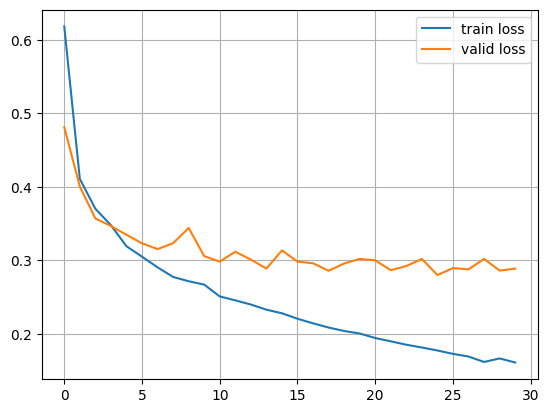

In [40]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.grid()

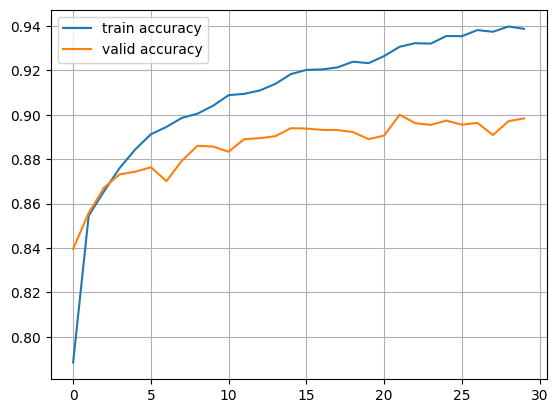

In [32]:
plt.plot(history.history["categorical_accuracy"], label="train accuracy")
plt.plot(history.history["val_categorical_accuracy"], label="valid accuracy")
plt.legend()
plt.grid()

# Conclusion

Best params:
1. learning_rate = 0.0005
1. n_units = [4000, 80]
1. batch_size = 512
1. layers = 2
1. activate_funcion = "relu"
1. optimizer = "AdamW"
1. Dropout = 0.3

Final accuracy = 0.8943